# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [14]:
# print('hello world')

In [15]:
import sys
# !conda install --yes --prefix {sys.prefix} osmnx
# !conda install --prefix {sys.prefix} osmnx
# !{sys.executable} -m pip install osmnx
# !{sys.executable} -m pip install shapely 

In [16]:
# print('hello world')

In [17]:
import collections
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

'1.1.1'

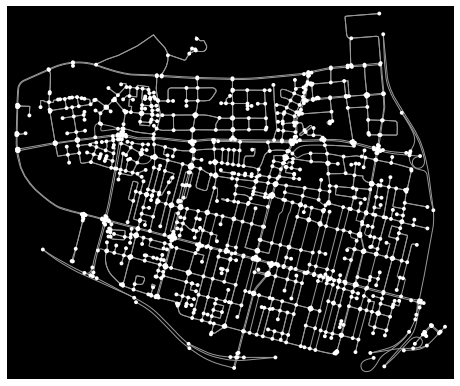

In [18]:
# get a graph for some city
G = ox.graph_from_place('Raanana, Israel', network_type='drive')
fig, ax = ox.plot_graph(G, node_zorder=2, node_color='w', bgcolor='k')

In [19]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

12413001.145159284

In [20]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\stats.py:317: UserWarning: The `circuity_dist` argument has been deprecated and will be removed in a future release.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\stats.py:327: UserWarning: The `clean_intersects` and `tolerance` arguments have been deprecated and will be removed in a future release. Use the `clean_int_tol` argument instead.
  warnings.warn(msg)


{'n': 1270,
 'm': 2617,
 'k_avg': 4.121259842519685,
 'edge_length_total': 263929.68899999966,
 'edge_length_avg': 100.8520019105845,
 'streets_per_node_avg': 2.8023622047244094,
 'streets_per_node_counts': {0: 0, 1: 216, 2: 14, 3: 851, 4: 183, 5: 6},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1700787401574803,
  2: 0.011023622047244094,
  3: 0.6700787401574804,
  4: 0.14409448818897638,
  5: 0.004724409448818898},
 'intersection_count': 1054,
 'street_length_total': 175345.35400000025,
 'street_segment_count': 1773,
 'street_length_avg': 98.89754878736619,
 'circuity_avg': 1.054177722536932,
 'self_loop_proportion': 0.001692047377326565,
 'clean_intersection_count': 588,
 'node_density_km': 102.3120827226592,
 'intersection_density_km': 84.91097259030141,
 'edge_density_km': 21262.359192073767,
 'street_density_km': 14125.943593292905,
 'clean_intersection_density_km': 47.36968869364064}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [21]:
# see more stats (mostly topological stuff) with extended_stats
more_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True) #use arguments to turn other toplogical analyses on/off
for key in sorted(more_stats.keys()):
    print(key)

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\stats.py:405: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


NetworkXError: random_state_index is incorrect

In [22]:
# pull up some stat's value
more_stats['radius']

NameError: name 'more_stats' is not defined

In [23]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath='./data/mynetwork.gpkg')
ox.save_graphml(G, filepath='./data/mynetwork.graphml')

## Visualize street centrality

In [24]:
# edge closeness centrality: convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

In [25]:
# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in G.edges()]

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(G, bgcolor='k', axis_off=True, node_size=0,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

TypeError: plot_graph() got an unexpected keyword argument 'axis_off'

## Routing

In [ ]:
# impute missing edge speeds then calculate edge travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [ ]:
# get the nearest network nodes to two points
orig = ox.get_nearest_node(G, (32.1776, 34.8594)) # Pellers House 
dest = ox.get_nearest_node(G, (32.18846730387055, 34.8720895189233))

In [ ]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, orig, dest, weight='travel_time')
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

In [ ]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
sum(edge_lengths)

In [ ]:
# how far is it between these two nodes as the crow flies?
ox.distance.great_circle_vec(G.nodes[orig]['y'], G.nodes[orig]['x'],
                             G.nodes[dest]['y'], G.nodes[dest]['x'])

In [ ]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
from keys import google_elevation_api_key
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)
G = ox.add_edge_grades(G)
nc = ox.plot.get_node_colors_by_attr(G, 'elevation', cmap='plasma')
fig, ax = ox.plot_graph(G, fig_height=6, node_color=nc, node_size=20, node_zorder=2,
                        edge_linewidth=2, edge_color='#333333', bgcolor='k')

Nodes are colored from lowest elevation (dark blue) to highest (bright yellow).

Example: create [elevation-based](12-node-elevations-edge-grades.ipynb) impedance functions to route around hills.

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

In [26]:
# you can make query an unambiguous dict to help the geocoder find it
place = {'city'   : 'San Francisco',
         'state'  : 'California',
         'country': 'USA'}
G = ox.graph_from_place(place, network_type='drive', truncate_by_edge=True)
fig, ax = ox.plot_graph(G, fig_height=10, node_size=0, bgcolor='k',
                        edge_color='orange', edge_linewidth=0.2)

TypeError: plot_graph() got an unexpected keyword argument 'fig_height'

In [ ]:
# you can get networks anywhere in the world
G = ox.graph_from_place('Sinalunga, Italy', network_type='all')
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, bgcolor='k')

In [ ]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609 #meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type='drive')
fig, ax = ox.plot_graph(G, node_size=0, bgcolor='k')

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

In [ ]:
# get NY subway rail network
G = ox.graph_from_place('New York City, New York',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        network_type='none', custom_filter='["railway"~"subway"]')

fig, ax = ox.plot_graph(G, node_size=0, edge_color='w', edge_linewidth=0.2, bgcolor='k')

## Get points of interest

...such as local amenities or other entities: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.pois.pois_from_place).

In [31]:
# get everything tagged amenity,
# and everything with landuse = retail or commercial,
# and everything with highway = bus_stop

tags = {'amenity' : True,
        'landuse' : ['retail', 'commercial'],
        'highway' : 'bus_stop'}

# tags = {'highway' : 'bus_stop'}
gdf = ox.geometries_from_place('Raanana, Israel', tags)
gdf.shape

(639, 89)

In [32]:
# view just the banks
gdf[gdf['amenity']=='bank'].dropna(axis=1, how='any')
# gdf[gdf['amenity']=='bus_station'].dropna(axis=1, how='any')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


amenity                 brand brand:wikidata  \
element_type osmid                                                     
node         273431667     bank  Bank Mizrahi Tefahot       Q2777129   
             385297364     bank            Bank Leumi        Q806641   
             1305560933    bank         Discount Bank        Q250362   
             1350040079    bank            Bank Leumi        Q806641   
             1350040086    bank         Bank Hapoalim       Q2666775   
             1462780997    bank         Bank Hapoalim       Q2666775   
             2390505494    bank         Bank Hapoalim       Q2666775   
             8168144408    bank    בנק דיסקונט לישראל        Q250362   

                                 brand:wikipedia             name  \
element_type osmid                                                  
node         273431667   en:Bank Mizrahi-Tefahot  בנק מזרחי טפחות   
             385297364             en:Bank Leumi        בנק לאומי   
             1305560933  en:Israel Discount Bank          מרכנתיל   
             1350040079            en:Bank Leumi        בנק לאומי   
             1350040086         en:Bank Hapoalim      בנק הפועלים   
             1462780997         en:Bank Hapoalim      בנק הפועלים   
             2390505494         en:Bank Hapoalim      בנק הפועלים   
             8168144408  en:Israel Discount Bank      בנק דיסקונט   

                                      name:en          name:he  \
element_type osmid                                               
node         273431667   Bank Mizrahi Tefahot  בנק מזרחי טפחות   
             385297364             Bank Leumi        בנק לאומי   
             1305560933            Mercantile          מרכנתיל   
             1350040079            Bank Leumi        בנק לאומי   
             1350040086         Bank Hapoalim      בנק הפועלים   
             1462780997         Bank Hapoalim      בנק הפועלים   
             2390505494         Bank Hapoalim      בנק הפועלים   
             8168144408         Bank Discount      בנק דיסקונט   

                                          geometry  
element_type osmid                                  
node         273431667   POINT (34.87753 32.18010)  
             385297364   POINT (34.87058 32.18161)  
             1305560933  POINT (34.87842 32.17950)  
             1350040079  POINT (34.85457 32.18579)  
             1350040086  POINT (34.85450 32.18569)  
             1462780997  POINT (34.87539 32.18055)  
             2390505494  POINT (34.88460 32.19652)  
             8168144408  POINT (34.87428 32.18040)

In [154]:
# view just the bus stops
# gdf[gdf['highway']=='bus_stop'].dropna(axis=1, how='any')
bus_stops = gdf[gdf['highway']=='bus_stop'].dropna(axis=1, how='any')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [146]:
bus_stops.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


name               name:he  \
element_type osmid                                                    
node         1802984777         שבזי/אבן עזרא         שבזי/אבן עזרא   
             1802986077  אוסטרובסקי/בן גוריון  אוסטרובסקי/בן גוריון   
             1802987140          ויצמן/החרושת          ויצמן/החרושת   
             1802987785      אחוזה/אליעזר יפה      אחוזה/אליעזר יפה   
             1802987789          אחוזה/ביאליק          אחוזה/ביאליק   

                                          geometry   highway  bus  \
element_type osmid                                                  
node         1802984777  POINT (34.86636 32.19044)  bus_stop  yes   
             1802986077  POINT (34.87085 32.17905)  bus_stop  yes   
             1802987140  POINT (34.88145 32.19201)  bus_stop  yes   
             1802987785  POINT (34.87461 32.18041)  bus_stop  yes   
             1802987789  POINT (34.88064 32.17926)  bus_stop  yes   

                        public_transport    ref       source  
element_type osmid                                            
node         1802984777         platform  32977  israel_gtfs  
             1802986077         platform  39963  israel_gtfs  
             1802987140         platform  34259  israel_gtfs  
             1802987785         platform  37057  israel_gtfs  
             1802987789         platform  37060  israel_gtfs

In [38]:
type(bus_stops)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


geopandas.geodataframe.GeoDataFrame

In [39]:
bus_stops.count()

name                154
name:he             154
geometry            154
highway             154
bus                 154
public_transport    154
ref                 154
source              154
dtype: int64

In [155]:
bus_stops_gemotry = bus_stops[['name', 'geometry']]
print("type(bus_stops_gemotry) = " + str(type(bus_stops_gemotry)))

type(bus_stops_gemotry) = <class 'geopandas.geodataframe.GeoDataFrame'>


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [202]:
class BusStop:
    name = "none"
    N = 0.0
    E = 0.0
    
    
    def __init__(self, _name, _N, _E):
        self.name = _name
        self.N = _N
        self.E = _E
    
    def __str__(self):
        return self.name + " " + str(self.N) + " " + str(self.E)
        
bus_stops_list = []

for a, series in bus_stops_gemotry.iterrows():
#     print("a = " + str(a) + ". type(a) = " + str(type(a)))
    new_name = series.get('name')
    coords = tuple(series.get('geometry').coords)[0]
    new_N = coords[0]
    new_E = coords[1]
    
    temp = BusStop(new_name, new_N, new_E)
    bus_stops_list.append(temp)
    
#     print(series.get('name'))
#     print(tuple(series.get('geometry').coords)[0][0])
#     print(tuple(series.get('geometry').coords)[0][1])
    
#     print("series = |||" + str(series) + "|||. type(series) = " + str(type(series)))
#     for _, point in series.items():
        
#         print((tuple(point.coords))[0][0])
#         print((tuple(point.coords))[0][1])
#     print(j)

print(len(bus_stops_list))
print((bus_stops_list[0]))

154
שבזי/אבן עזרא 34.86636 32.190439


In [138]:
# bus_stops_gemotry.cx[:, :0]
# type(bus_stops_gemotry.cx[:, :0])
temp = bus_stops_gemotry.iloc[0,:]
print("type(bus_stops_gemotry.iloc[0,:]) = " + str(type(bus_stops_gemotry.iloc[0,:])))
# type(temp)
for i, j in temp.items():
    print("i = " + str(i) + ". type(i) = " + str(type(i)) + "\n")
    print("j = " + str(j) + ". type(j) = " + str(type(j)) + "\n")
    print((tuple(j.coords))[0][0])
#     print(type(list(j.coords)))
# type(bus_stops_gemotry.iloc[0,:])

type(bus_stops_gemotry.iloc[0,:]) = <class 'pandas.core.series.Series'>
i = geometry. type(i) = <class 'str'>

j = POINT (34.86636 32.190439). type(j) = <class 'shapely.geometry.point.Point'>

34.86636
